# Generate Paper Figures

In [30]:
from glob import glob
from scipy.optimize import least_squares
import pickle
from matplotlib.gridspec import GridSpec
import seaborn as sns

from waveCal import *

plt.style.use('seaborn-colorblind')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

label_font=14
title_font=16

## Gather Files

In [31]:
# LFC
ckpt_files, lfc_files, lfc_times = findFiles(start_date='191004',
                                             end_date  ='191218',
                                             cal_source='lfc')
time_sort = np.argsort(lfc_times)
ckpt_files = ckpt_files[time_sort]
lfc_files = lfc_files[time_sort]
lfc_times = lfc_times[time_sort]
num_lfc_files = len(lfc_files)
print(num_lfc_files)

100%|██████████| 6060/6060 [01:22<00:00, 73.70it/s]

1228


In [32]:
# ThAr
thid_files, thar_files, thar_times = findFiles(start_date='191004', 
                                               end_date  ='191218',
                                               cal_source='thar')
time_sort = np.argsort(thar_times)
thid_files = thid_files[time_sort]
thar_files = thar_files[time_sort]
thar_times = thar_times[time_sort]
num_thar_files = len(thar_files)
print(num_thar_files)

100%|██████████| 1979/1979 [00:17<00:00, 115.37it/s]

78


## Get and Save Patch Dictionaries

In [33]:
ckpt_patch_file = './Epoch_Patches/ckptPatch_5-4.pkl'
ckpt_patch = pickle.load(open(ckpt_patch_file, 'rb'))

In [34]:
thid_patch_file = './Epoch_Patches/thidPatch_5-4.pkl'
thid_patch = pickle.load(open(thid_patch_file, 'rb'))

In [35]:
thid_patch['denoised_xs'].shape

(78, 5295)

In [36]:
len(np.unique(thid_patch['orders']))

86

## PCA Results

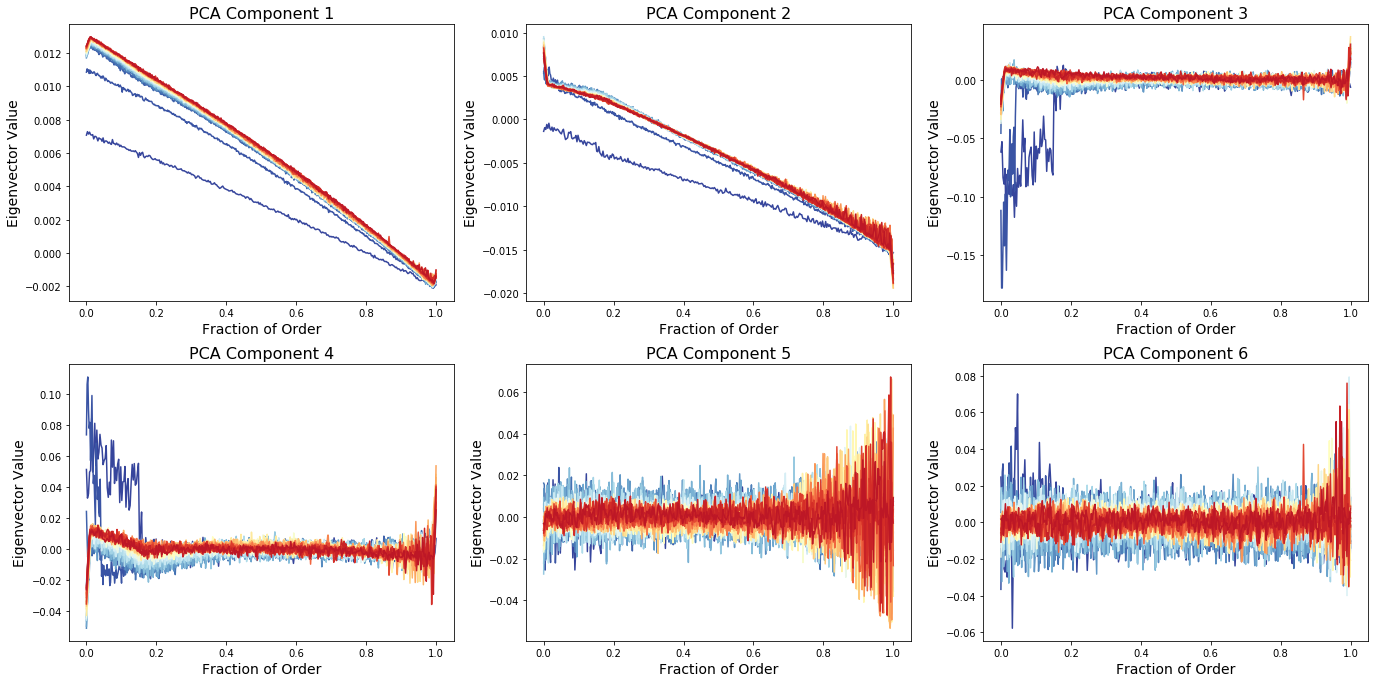

In [37]:
# PCA Components Plot
# How do the eigenvectors compare with each iteration
plt.figure(figsize=(6.4*3,4.8*2))
orders = ckpt_patch['orders']
unq_orders = np.unique(orders)
vvs = ckpt_patch['v']
colors = sns.color_palette("RdYlBu_r",len(unq_orders))
for i in range(1,7):
    plt.subplot(2,3,i)
    plt.title(f'PCA Component {i}',fontsize=title_font)
    plt.xlabel('Fraction of Order',fontsize=label_font)
    plt.ylabel('Eigenvector Value',fontsize=label_font)
    
    for j, nord in enumerate(unq_orders[:-1]):
        ord_mask = orders==nord
        plt.plot(np.linspace(0,1,np.sum(ord_mask)-2),
                 vvs[i-1][orders==nord][1:-1],color=colors[j])
plt.tight_layout()
plt.savefig('./Figures/Paper/pcsLfc.pdf')
plt.savefig('./Figures/Paper/pcsLfc.png')

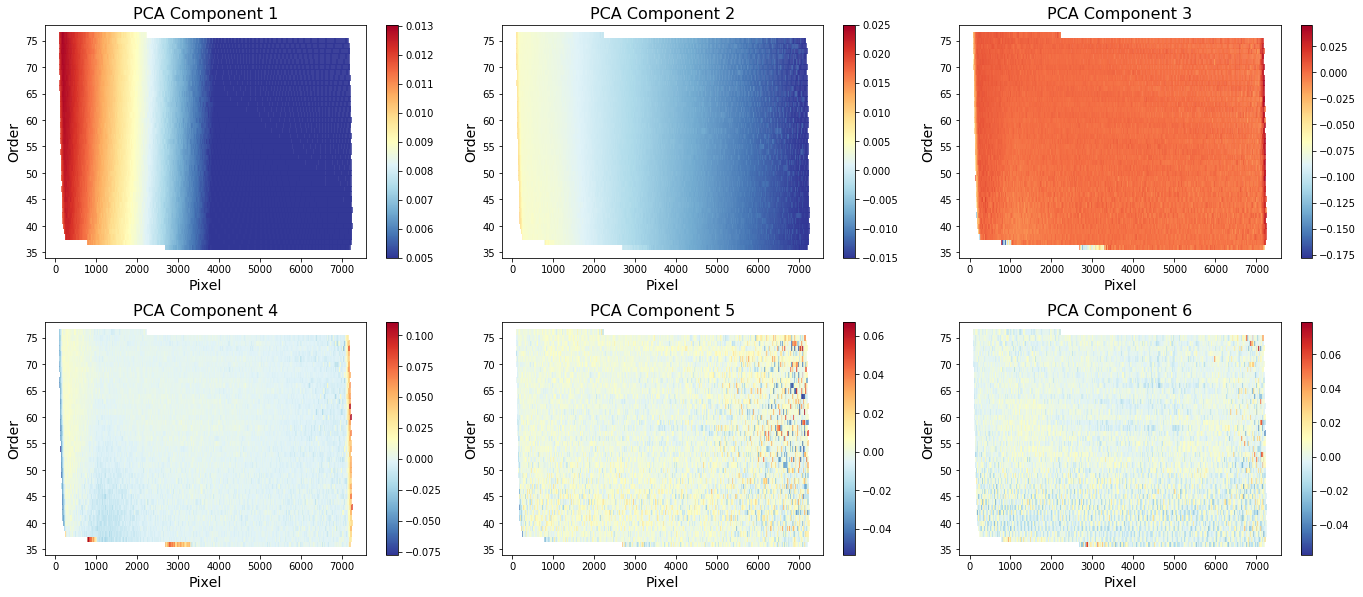

In [38]:
# PCA Components Plot
# How do the eigenvectors compare with each iteration
nepc=6
plt.figure(figsize=(6.4*3,4.8*1.75))
orders = ckpt_patch['orders']
unq_orders = np.unique(orders)
vvs = ckpt_patch['v']
colors = sns.color_palette("RdYlBu",len(unq_orders))
for i in range(1,nepc+1):
    plt.subplot(2,3,i)
    plt.title(f'PCA Component {i}',fontsize=title_font)
    plt.xlabel('Pixel',fontsize=label_font)
    plt.ylabel('Order',fontsize=label_font)
    
    if i==1:
        plt.scatter(ckpt_patch['denoised_xs'][nepc],ckpt_patch['orders'],
                    c=vvs[i-1],cmap='RdYlBu_r',vmin=0.005,marker='|')
    elif i==2:
        plt.scatter(ckpt_patch['denoised_xs'][nepc],ckpt_patch['orders'],
                    c=vvs[i-1],cmap='RdYlBu_r',vmin=-0.015,vmax=0.025,marker='|')
    else:
        plt.scatter(ckpt_patch['denoised_xs'][nepc],ckpt_patch['orders'],
                    c=vvs[i-1],cmap='RdYlBu_r',marker='|')
    plt.colorbar()
plt.tight_layout()
plt.savefig(f'./Figures/Paper/pcsLfc{nepc}.pdf')
plt.savefig(f'./Figures/Paper/pcsLfc{nepc}.png')

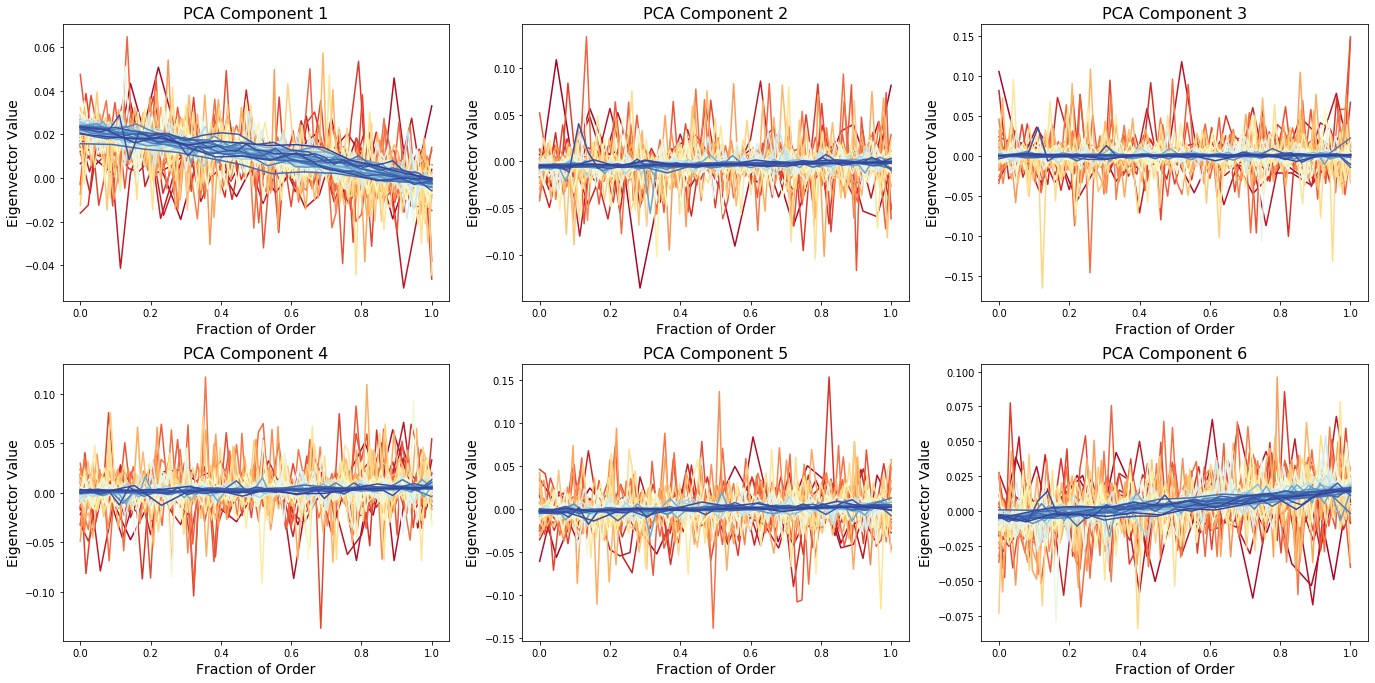

In [39]:
# PCA Components Plot
# How do the eigenvectors compare with each iteration
plt.figure(figsize=(6.4*3,4.8*2))
orders = thid_patch['orders']
unq_orders = np.unique(orders)
vvs = thid_patch['v']
colors = sns.color_palette("RdYlBu",len(unq_orders))
for i in range(1,7):
    plt.subplot(2,3,i)
    plt.title(f'PCA Component {i}',fontsize=title_font)
    plt.xlabel('Fraction of Order',fontsize=label_font)
    plt.ylabel('Eigenvector Value',fontsize=label_font)
    
    for j, nord in enumerate(unq_orders[:-1]):
        ord_mask = orders==nord
        plt.plot(np.linspace(0,1,np.sum(ord_mask)-2),
                 vvs[i-1][orders==nord][1:-1],color=colors[j])
plt.tight_layout()
plt.savefig('./Figures/Paper/pcsThar.pdf')
plt.savefig('./Figures/Paper/pcsThar.png')

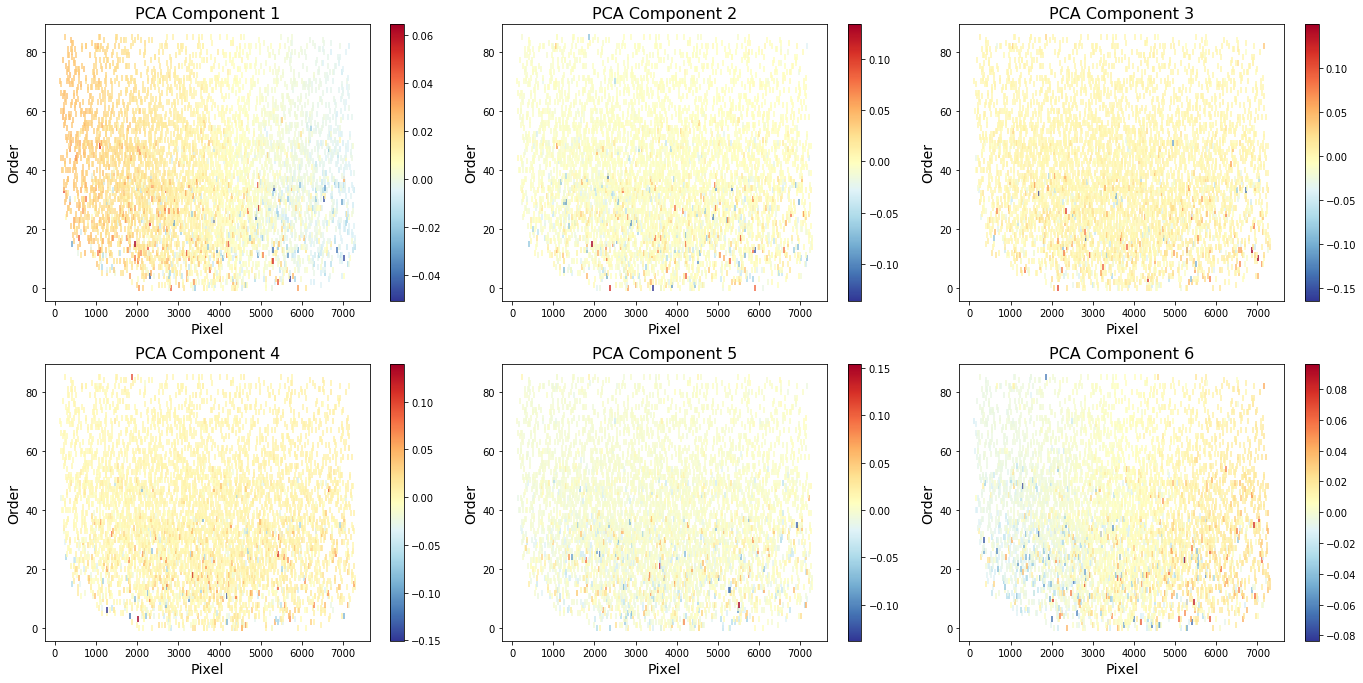

In [40]:
# PCA Components Plot
# How do the eigenvectors compare with each iteration
nepc=6
plt.figure(figsize=(6.4*3,4.8*2))
orders = thid_patch['orders']
unq_orders = np.unique(orders)
vvs = thid_patch['v']
colors = sns.color_palette("RdYlBu",len(unq_orders))
for i in range(1,7):
    plt.subplot(2,3,i)
    plt.title(f'PCA Component {i}',fontsize=title_font)
    plt.xlabel('Pixel',fontsize=label_font)
    plt.ylabel('Order',fontsize=label_font)
    
    plt.scatter(thid_patch['denoised_xs'][nepc],thid_patch['orders'],c=vvs[i-1],
                cmap='RdYlBu_r',marker='|')
    plt.colorbar()
plt.tight_layout()
plt.savefig(f'./Figures/Paper/pcsThAr{nepc}.pdf')
plt.savefig(f'./Figures/Paper/pcsThAr{nepc}.png')

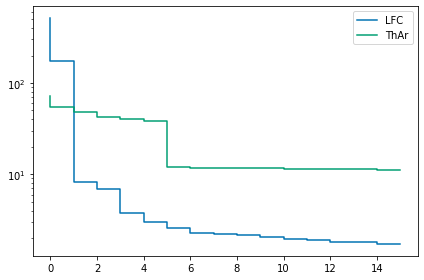

In [41]:
# Eigenvector figure
plt.step(np.arange(16),ckpt_patch['s'][:16],label='LFC')
plt.step(np.arange(16),thid_patch['s'][:16],label='ThAr')
plt.gca().set_yscale('log')
plt.legend()
plt.tight_layout()
plt.savefig('./Figures/Paper/ss.pdf')
plt.savefig('./Figures/Paper/ss.png')

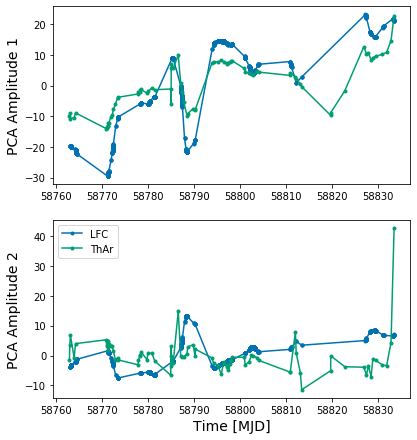

In [42]:
# PCA Amplitude Variation with Time
plt.figure(figsize=(6.4,4.8*1.5))
plt.subplot(211)
plt.plot(ckpt_patch['times'],ckpt_patch['ec'][:,0],'.-')
plt.plot(thid_patch['times'],thid_patch['ec'][:,0],'.-')
plt.ylabel('PCA Amplitude 1',fontsize=label_font)

plt.subplot(212)
plt.plot(ckpt_patch['times'],ckpt_patch['ec'][:,1],'.-',label='LFC')
plt.plot(thid_patch['times'],thid_patch['ec'][:,1],'.-',label='ThAr')
plt.ylabel('PCA Amplitude 2',fontsize=label_font)
plt.xlabel('Time [MJD]',fontsize=label_font)
plt.legend()
plt.savefig('./Figures/Paper/pcAs.pdf')
plt.savefig('./Figures/Paper/pcAs.png')

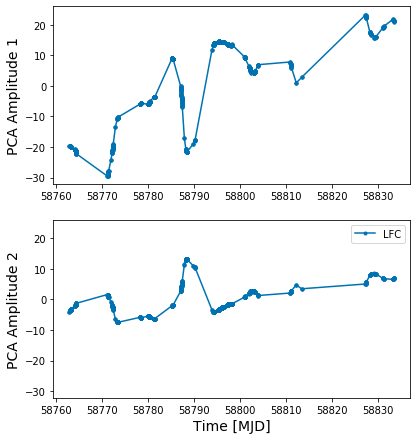

In [43]:
# PCA Amplitude Variation with Time
plt.figure(figsize=(6.4,4.8*1.5))
plt.subplot(211)
plt.plot(ckpt_patch['times'],ckpt_patch['ec'][:,0],'.-')
plt.ylabel('PCA Amplitude 1',fontsize=label_font)
plt.ylim(-32.2,26)

plt.subplot(212)
plt.plot(ckpt_patch['times'],ckpt_patch['ec'][:,1],'.-',label='LFC')
plt.ylabel('PCA Amplitude 2',fontsize=label_font)
plt.xlabel('Time [MJD]',fontsize=label_font)
plt.ylim(-32.2,26)
plt.legend()
plt.savefig('./Figures/Paper/pcA_lfc.pdf')
plt.savefig('./Figures/Paper/pcA_lfc.png')

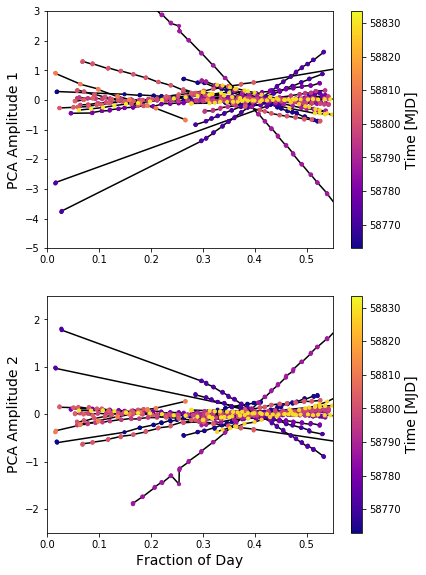

In [44]:
# PCA Amplitude Interpolation w.r.t. Time
fig = plt.figure(figsize=(6.4,4.8*2))
ax1 = plt.subplot(211)
ax1.set_ylabel('PCA Amplitude 1',fontsize=label_font)
ax2 = plt.subplot(212)
ax2.set_ylabel('PCA Amplitude 2',fontsize=label_font)
ax2.set_xlabel('Fraction of Day',fontsize=label_font)
time_min = np.min([ckpt_patch['times'].min(),thid_patch['times'].min()])
time_max = np.max([ckpt_patch['times'].max(),thid_patch['times'].max()])

cur_day = int(ckpt_patch['times'].min())
cur_tims = []
cur_amps = []
for j,i in enumerate(ckpt_patch['times']):
    if int(i)==cur_day:
        cur_tims.append(i)
        cur_amps.append(ckpt_patch['ec'][j])
    else:
        cur_tims = np.array(cur_tims)
        cur_amps = np.array(cur_amps)
        ax1.plot(cur_tims%1,cur_amps[:,0]-np.median(cur_amps[:,0]),'k-',zorder=0)
        ax1.scatter(cur_tims%1,cur_amps[:,0]-np.median(cur_amps[:,0]),c=cur_tims,
                    cmap='plasma',vmin=time_min,vmax=time_max,zorder=1,s=10)
        
        ax2.plot(cur_tims%1,cur_amps[:,1]-np.median(cur_amps[:,1]),'k-',zorder=0)
        amps = ax2.scatter(cur_tims%1,cur_amps[:,1]-np.median(cur_amps[:,1]),c=cur_tims,
                    cmap='plasma',vmin=time_min,vmax=time_max,zorder=1,s=10)
        cur_day=int(i)
        cur_tims = [i]
        cur_amps = [ckpt_patch['ec'][j]]

ax1.set_xlim(0,.55)
ax1.set_ylim(-5,3)
cbar = fig.colorbar(amps, ax=ax1, cmap='plasma')
cbar.set_label('Time [MJD]',fontsize=label_font)
ax2.set_xlim(0,.55)
ax2.set_ylim(-2.5,2.5)
cbar = fig.colorbar(amps, ax=ax2, cmap='plasma')
cbar.set_label('Time [MJD]',fontsize=label_font)
plt.savefig('./Figures/Paper/pcAs_byDay.pdf')
plt.savefig('./Figures/Paper/pcAs_byDay.png')

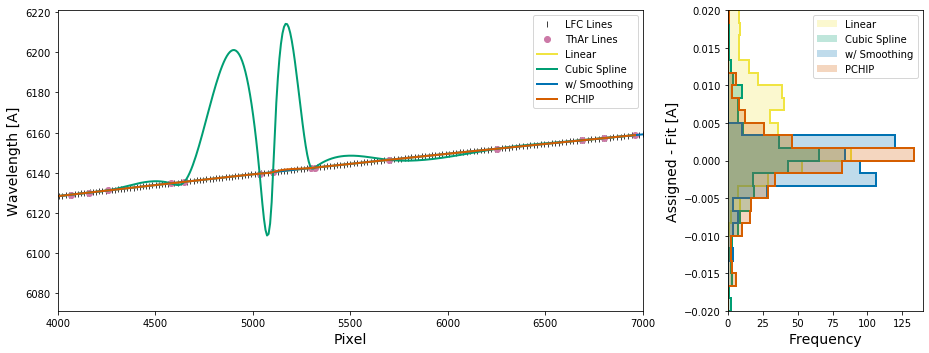

In [45]:
# PCA Amplitude Interpolation w.r.t. Pixel
plt.style.use('seaborn-colorblind')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

fig  = plt.figure(figsize=(6.4*2,4.8),constrained_layout=True)
spec = GridSpec(ncols=4,nrows=1,figure=fig)
ax   = fig.add_subplot(spec[0,:-1])
ax.set_xlabel('Pixel',fontsize=label_font)
ax.set_ylabel('Wavelength [A]',fontsize=label_font)
axr  = fig.add_subplot(spec[0,-1])
axr.set_xlabel('Frequency',fontsize=label_font)
axr.set_ylabel('Assigned - Fit [A]',fontsize=label_font)

nepc=0
nord=60

thid_patch_file = './Data/200110_thidPatch.pkl'
thid_patch = pickle.load(open(thid_patch_file, 'rb'))
dnxs = evalWaveSol(ckpt_patch['times'][nepc], thid_patch, intp_deg=1)[0]

x,m,w,e = readParams(ckpt_patch['files'][nepc])
IA = m==nord
I  = thid_patch['orders'].astype(int)==nord

dnxs = evalWaveSol(ckpt_patch['times'][nepc], thid_patch, intp_deg=1)[0]

ax.plot(x[IA],w[IA],'k|',alpha=0.75,label='LFC Lines')
ax.plot(dnxs[I],thid_patch['waves'][I],'o',color=colors[3],label='ThAr Lines')

newx = np.linspace(0,7920,1000)
f0 = interpolate.interp1d(dnxs[I],thid_patch['waves'][I],kind='linear',
                         bounds_error=False,fill_value=np.nan)
ax.plot(newx,f0(newx),'-',color=colors[4],lw=2,label='Linear')

f1 = interpolate.interp1d(dnxs[I],thid_patch['waves'][I],kind='cubic',
                         bounds_error=False,fill_value=np.nan)
ax.plot(newx,f1(newx),'-',color=colors[1],lw=2,label='Cubic Spline')

f2 = interpolate.UnivariateSpline(dnxs[I],thid_patch['waves'][I])
ax.plot(newx,f2(newx),'-',color=colors[0],lw=2,label='w/ Smoothing')

f3 = interpolate.PchipInterpolator(dnxs[I],thid_patch['waves'][I],extrapolate=False)
ax.plot(newx,f3(newx),'-',color=colors[2],lw=2,label='PCHIP')

ax.legend()
ax.set_xlim(4000,7000)
#plt.ylim(6120,6160)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

axr.hist(w[IA]-f0(x[IA]),bins=np.linspace(-0.02,0.02,25),alpha=0.25,
         color=colors[4],orientation='horizontal',label='Linear')
axr.hist(w[IA]-f0(x[IA]),bins=np.linspace(-0.02,0.02,25),lw=2,
         color=colors[4],orientation='horizontal',histtype='step')
axr.hist(w[IA]-f1(x[IA]),bins=np.linspace(-0.02,0.02,25),alpha=0.25,
         color=colors[1],orientation='horizontal',label='Cubic Spline')
axr.hist(w[IA]-f1(x[IA]),bins=np.linspace(-0.02,0.02,25),lw=2,
         color=colors[1],orientation='horizontal',histtype='step')
axr.hist(w[IA]-f2(x[IA]),bins=np.linspace(-0.02,0.02,25),alpha=0.25,
         color=colors[0],orientation='horizontal',label='w/ Smoothing')
axr.hist(w[IA]-f2(x[IA]),bins=np.linspace(-0.02,0.02,25),lw=2,
         color=colors[0],orientation='horizontal',histtype='step')
axr.hist(w[IA]-f3(x[IA]),bins=np.linspace(-0.02,0.02,25),alpha=0.25,
         color=colors[2],orientation='horizontal',label='PCHIP')
axr.hist(w[IA]-f3(x[IA]),bins=np.linspace(-0.02,0.02,25),lw=2,
         color=colors[2],orientation='horizontal',histtype='step')
axr.legend()
axr.set_ylim(-0.02,0.02)

#plt.tight_layout()
plt.savefig('./Figures/Paper/intpx_tests.pdf')
plt.savefig('./Figures/Paper/intpx_tests.png')

thid_patch_file = './Data/200324_thidPatch_K4.pkl'
thid_patch = pickle.load(open(thid_patch_file, 'rb'))

## Results

### Self Tests

#### LFC

In [46]:
nfile=6
print(os.path.basename(ckpt_files[nfile]))
print(Time(lfc_times[nfile],format='mjd').isot)

denoised_x = evalWaveSol(lfc_times[nfile], ckpt_patch, intp_deg=1)[0]

LFC_191007.1069.npy
2019-10-07T04:18:14.415


##### With Denoised X Values
(Should be zero to machine error)

In [47]:
m = ckpt_patch['orders'].copy()
w = ckpt_patch['waves'].copy()
newx = ckpt_patch['denoised_xs'].copy()[nfile]
newm = m.copy()
w_fit = interp_train_and_predict(newx, newm, denoised_x, m, w, e=None, interp_deg='pchip')

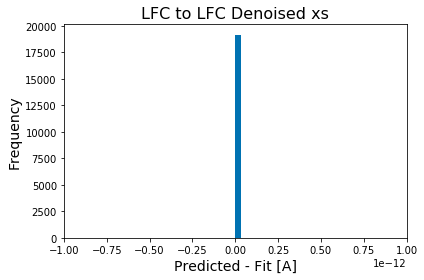

In [48]:
good_mask = np.isfinite(w_fit)
resid = w_fit[good_mask]-w[good_mask]
rv_shift = resid/w[good_mask]*c.value

plt.figure()
plt.title('LFC to LFC Denoised xs',fontsize=title_font)
plt.xlabel('Predicted - Fit [A]',fontsize=label_font)
plt.ylabel('Frequency',fontsize=label_font)
#plt.hist(rv_shift,50);
plt.hist(resid,50);
plt.tight_layout()
plt.savefig('./Figures/Paper/lfcLfcDenoised.png')
plt.savefig('./Figures/Paper/lfcLfcDenoised.pdf')

##### With Fitted s Values
(Shows error floor of our data-based tests)

In [49]:
nfile=11
print(os.path.basename(ckpt_files[nfile]))
print(Time(lfc_times[nfile],format='mjd').isot)

denoised_x = evalWaveSol(lfc_times[nfile], ckpt_patch, intp_deg=1)[0]

LFC_191007.1080.npy
2019-10-07T05:17:27.814


In [50]:
m = ckpt_patch['orders'].copy()
w = ckpt_patch['waves'].copy()
newx, newm, neww, newe = readParams(ckpt_files[nfile])
w_fit = interp_train_and_predict(newx, newm, denoised_x, m, w, e=None, interp_deg='pchip')

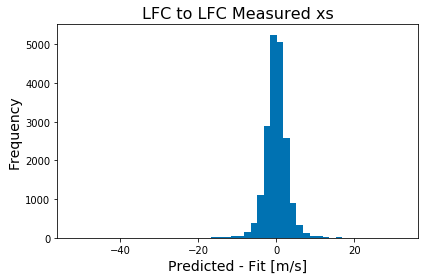

In [51]:
good_mask = np.isfinite(w_fit)
resid = w_fit[good_mask]-neww[good_mask]
rv_shifts_lfcSelf = resid/neww[good_mask]*c.value

plt.figure()
plt.title('LFC to LFC Measured xs',fontsize=title_font)
plt.xlabel('Predicted - Fit [m/s]',fontsize=label_font)
plt.ylabel('Frequency',fontsize=label_font)
plt.hist(rv_shifts_lfcSelf,50);
plt.tight_layout()
plt.savefig('./Figures/Paper/fcLfcMeasured.png')
plt.savefig('./Figures/Paper/fcLfcMeasured.pdf')

In [53]:
lfc_fits = []
lfc_info = []
for file_num in tqdm(range(len(ckpt_patch['times']))):
    file_name = ckpt_patch['files'][file_num]
    file_time = ckpt_patch['times'][file_num]
    try:
        newx, newm, neww, newe = readParams(file_name)
    except ValueError as err:
        continue
    
    denoised_xs = evalWaveSol(file_time, ckpt_patch, intp_deg=1)[0]
    m = ckpt_patch['orders'].copy()
    w = ckpt_patch['waves'].copy()
    try:
        w_fit = interp_train_and_predict(newx, newm,
                                         denoised_xs, m, w,
                                         e=None, interp_deg='pchip')
    except AssertionError:
        continue
    lfc_fits.append(w_fit)
    lfc_info.append([newx,newm,neww,newe])

100%|██████████| 1227/1227 [01:09<00:00, 16.20it/s]


3.6115921814571443


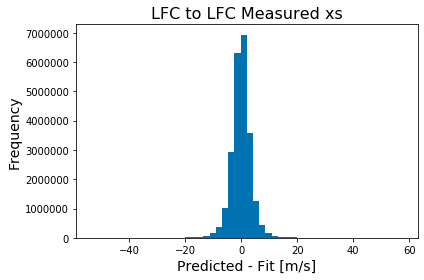

In [54]:
resids, rv_shifts_lfcSelf = [], []
for i in range(len(lfc_fits)):
    good_mask = np.isfinite(lfc_fits[i])
    resid = lfc_fits[i][good_mask]-lfc_info[i][2][good_mask]
    rv_shift = resid/lfc_info[i][2][good_mask] * c.value
    
    resids.append(resid)
    rv_shifts_lfcSelf.append(rv_shift)

plt.figure()
plt.title('LFC to LFC Measured xs',fontsize=title_font)
plt.xlabel('Predicted - Fit [m/s]',fontsize=label_font)
plt.ylabel('Frequency',fontsize=label_font)
plt.hist(np.sort(np.concatenate(rv_shifts_lfcSelf))[100:-100],50);
plt.tight_layout()
plt.savefig('./Figures/Paper/tharTharMeasured.png')
plt.savefig('./Figures/Paper/tharTharMeasured.pdf')
print(np.std(np.concatenate(rv_shifts_lfcSelf)))

#### ThAr

In [146]:
nfile=11
print(os.path.basename(thid_files[nfile]))
print(Time(thar_times[nfile],format='mjd').isot)

denoised_x = evalWaveSol(thar_times[nfile], thid_patch, intp_deg=1)[0]

ThAr_191015.1230.thid
2019-10-15T12:47:02.314


##### With Denoised X Values
(Should be zero to machine error)

In [147]:
m = thid_patch['orders'].copy()
w = thid_patch['waves'].copy()
newx = thid_patch['denoised_xs'].copy()[nfile]
newm = m.copy()
w_fit = interp_train_and_predict(newx, newm, denoised_x, m, w, e=None, interp_deg='pchip')

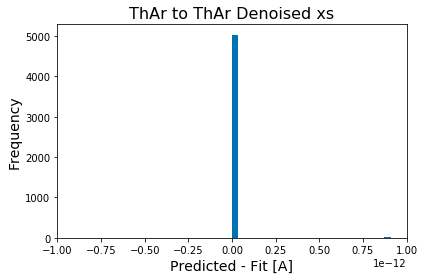

In [148]:
good_mask = np.isfinite(w_fit)
resid = w_fit[good_mask]-w[good_mask]
rv_shift = resid/w[good_mask]*c.value

plt.figure()
plt.title('ThAr to ThAr Denoised xs',fontsize=title_font)
plt.xlabel('Predicted - Fit [A]',fontsize=label_font)
plt.ylabel('Frequency',fontsize=label_font)
#plt.hist(rv_shift,50);
plt.hist(resid,50);
plt.tight_layout()
plt.savefig('./Figures/Paper/tharTharDenoised.png')
plt.savefig('./Figures/Paper/tharTharDenoised.pdf')

##### With Fitted s Values
(Shows error floor of our data-based tests)

In [149]:
thar_fits = []
thar_info = []
for file_num in tqdm(range(len(thid_patch['times']))):
    file_name = thid_patch['files'][file_num]
    file_time = thid_patch['times'][file_num]
    try:
        newx, newm, neww = readThid(file_name)
    except ValueError as err:
        continue
    
    denoised_xs = evalWaveSol(file_time, thid_patch, intp_deg=1)[0]
    m = thid_patch['orders'].copy()
    w = thid_patch['waves'].copy()
    try:
        w_fit = interp_train_and_predict(newx, newm,
                                         denoised_xs, m, w,
                                         e=None, interp_deg='pchip')
    except AssertionError:
        continue
    thar_fits.append(w_fit)
    thar_info.append([newx,newm,neww])

  9%|▉         | 7/78 [00:00<00:03, 21.55it/s]

7 2568.4541653600236
7 2568.3636494307443
7 2568.480271258431
7 2568.439163556038
7 2568.3748481636185


 41%|████      | 32/78 [00:01<00:01, 23.67it/s]

7 2568.599615677239
7 2568.511822085229


 50%|█████     | 39/78 [00:01<00:01, 24.78it/s]

7 2568.587587495335
7 2568.492764181114


 62%|██████▏   | 48/78 [00:01<00:01, 25.21it/s]

7 2568.748008897195


 85%|████████▍ | 66/78 [00:02<00:00, 22.14it/s]

7 2568.563217016658


 96%|█████████▌| 75/78 [00:03<00:00, 24.53it/s]

7 2568.7992901043895


100%|██████████| 78/78 [00:03<00:00, 24.91it/s]

7 2568.5712224839826


162.0934540824205


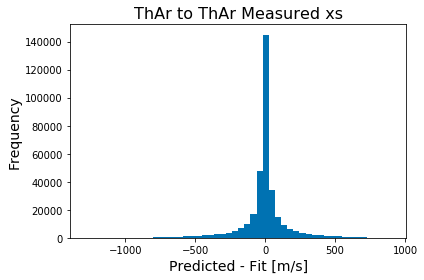

In [150]:
resids, rv_shifts_tharSelf = [], []
for i in range(len(thar_fits)):
    good_mask = np.isfinite(thar_fits[i])
    resid = thar_fits[i][good_mask]-thar_info[i][2][good_mask]
    rv_shift = resid/thar_info[i][2][good_mask] * c.value
    
    resids.append(resid)
    rv_shifts_tharSelf.append(rv_shift)

plt.figure()
plt.title('ThAr to ThAr Measured xs',fontsize=title_font)
plt.xlabel('Predicted - Fit [m/s]',fontsize=label_font)
plt.ylabel('Frequency',fontsize=label_font)
plt.hist(np.sort(np.concatenate(rv_shifts_tharSelf))[100:-100],50);
plt.tight_layout()
plt.savefig('./Figures/Paper/tharTharMeasured.png')
plt.savefig('./Figures/Paper/tharTharMeasured.pdf')
print(np.std(np.concatenate(rv_shifts_tharSelf)))

### Cross Tests

#### LFC -> ThAr

In [151]:
time_mask = np.logical_and(thid_patch['times'] > ckpt_patch['times'].min(),
                           thid_patch['times'] < ckpt_patch['times'].max())

In [152]:
thar_fits = []
thar_info = []
for file_num in tqdm(range(np.sum(time_mask))):
    file_name = thid_patch['files'][time_mask][file_num]
    file_time = thid_patch['times'][time_mask][file_num]
    try:
        newx, newm, neww = readThid(file_name)
    except ValueError as err:
        continue
    
    denoised_xs = evalWaveSol(file_time, ckpt_patch, intp_deg=1)[0]
    m = ckpt_patch['orders'].copy()
    w = ckpt_patch['waves'].copy()
    
    w_fit = interp_train_and_predict(newx, newm,
                                     denoised_xs, m, w,
                                     e=None, interp_deg='pchip')
    thar_fits.append(w_fit)
    thar_info.append([newx,newm,neww])

100%|██████████| 76/76 [00:01<00:00, 52.18it/s]


154.58111593221432


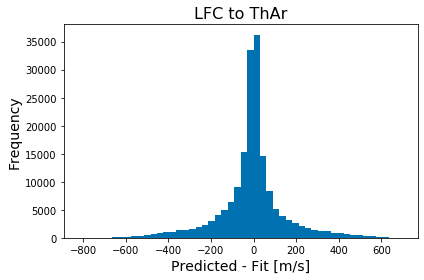

In [153]:
resids, rv_shifts_lfcThar = [], []
for i in range(len(thar_fits)):
    good_mask = np.isfinite(thar_fits[i])
    resid = thar_fits[i][good_mask]-thar_info[i][2][good_mask]
    rv_shift = resid/thar_info[i][2][good_mask] * c.value
    
    resids.append(resid)
    rv_shifts_lfcThar.append(rv_shift)
    
plt.figure()
plt.title('LFC to ThAr',fontsize=title_font)
plt.xlabel('Predicted - Fit [m/s]',fontsize=label_font)
plt.ylabel('Frequency',fontsize=label_font)
plt.hist(np.concatenate(rv_shifts_lfcThar),50);
plt.tight_layout()
plt.savefig('./Figures/Paper/lfcThar.png')
plt.savefig('./Figures/Paper/lfcThar.pdf')
print(np.std(np.concatenate(rv_shifts_lfcThar)))

#### ThAr -> LFC

In [154]:
time_mask = np.logical_and(ckpt_patch['times'] > thid_patch['times'].min(),
                           ckpt_patch['times'] < thid_patch['times'].max())

In [155]:
lfc_fits = []
lfc_dnxs = []
lfc_info = []
for file_num in tqdm(range(np.sum(time_mask))):
    file_name = ckpt_patch['files'][time_mask][file_num]
    file_time = ckpt_patch['times'][time_mask][file_num]
    try:
        newx,newm,neww,newe = readParams(file_name)
    except ValueError as err:
        continue
    
    denoised_xs = evalWaveSol(file_time, thid_patch, intp_deg=1)[0]
    m = thid_patch['orders'].copy()
    w = thid_patch['waves'].copy()
    
    w_fit = interp_train_and_predict(newx, newm,
                                     denoised_xs, m, w,
                                     orders=range(45,76),
                                     e=None, interp_deg='pchip')
    lfc_fits.append(w_fit)
    lfc_dnxs.append(denoised_xs)
    lfc_info.append([newx,newm,neww,newe])

100%|██████████| 1227/1227 [00:15<00:00, 77.28it/s]


221.60910527925907


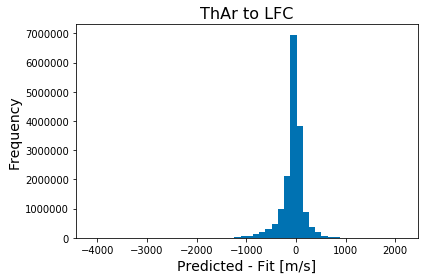

In [156]:
resids, rv_shifts_tharLfc = [], []
for i in range(len(lfc_fits)):
    good_mask = np.isfinite(lfc_fits[i])
    resid = lfc_fits[i][good_mask]-lfc_info[i][2][good_mask]
    rv_shift = resid/lfc_info[i][2][good_mask] * c.value
    
    resids.append(resid)
    rv_shifts_tharLfc.append(rv_shift)
    
plt.figure()
plt.title('ThAr to LFC',fontsize=title_font)
plt.xlabel('Predicted - Fit [m/s]',fontsize=label_font)
plt.ylabel('Frequency',fontsize=label_font)
plt.hist(np.concatenate(rv_shifts_tharLfc),50);
plt.tight_layout()
plt.savefig('./Figures/Paper/tharLfc.png')
plt.savefig('./Figures/Paper/tharLfc.pdf')
print(np.std(np.concatenate(rv_shifts_tharLfc)))

### Training and Validation Tests

In [157]:
np.random.seed(0)
# Make sure validation exposures are not first or last exposure
valid_idx = np.random.choice(num_lfc_files-2, num_lfc_files//10, replace=False)+1

lfc_train = np.delete(ckpt_files,valid_idx)
lfc_times_train = np.delete(lfc_times,valid_idx)
time_sort = np.argsort(lfc_times_train)
lfc_train = lfc_train[time_sort]
lfc_times_train = lfc_times_train[time_sort]

lfc_valid = ckpt_files[valid_idx]
lfc_times_valid = lfc_times[valid_idx]
time_sort = np.argsort(lfc_times_valid)
lfc_valid = lfc_valid[time_sort]
lfc_times_valid = lfc_times_valid[time_sort]

In [158]:
np.random.seed(0)
valid_idx = np.random.choice(num_thar_files-2, num_thar_files//10, replace=False)+1

thar_train = np.delete(thid_files,valid_idx)
thar_times_train = np.delete(thar_times,valid_idx)
time_sort = np.argsort(thar_times_train)
thar_train = thar_train[time_sort]
thar_times_train = thar_times_train[time_sort]

thar_valid = thid_files[valid_idx]
thar_times_valid = thar_times[valid_idx]
time_sort = np.argsort(thar_times_valid)
thar_valid = thar_train[time_sort]
thar_times_valid = thar_times_valid[time_sort]

#### Get and Save Patch Dictionaries

In [159]:
ckpt_patch_train = pickle.load(open('./Data/200324_ckptPatch_T.pkl', 'rb'))
lfc_valid, lfc_times_valid = pickle.load(open('./Data/200324_ckptPatch_V.pkl', 'rb'))

In [160]:
thid_patch_train = pickle.load(open('./Data/200324_thidPatch_T.pkl', 'rb'))
thar_valid, thar_times_valid = pickle.load(open('./Data/200324_thidPatch_V.pkl','rb'))

#### LFC Validation Test

In [161]:
lfc_fits = []
lfc_info = []
for file_num in tqdm(range(len(lfc_valid))):
    file_name = lfc_valid[file_num]
    file_time = lfc_times_valid[file_num]
    try:
        newx,newm,neww,newe = readParams(file_name)
    except ValueError as err:
        continue
        
    denoised_xs = evalWaveSol(file_time, ckpt_patch_train, intp_deg=1)[0]
    m = ckpt_patch_train['orders'].copy()
    w = ckpt_patch_train['waves'].copy()
    
    w_fit = interp_train_and_predict(newx, newm,
                                     denoised_xs, m, w,
                                     orders=range(46,68),
                                     e=None, interp_deg='pchip')
    lfc_fits.append(w_fit)
    lfc_info.append([newx,newm,neww,newe])

100%|██████████| 122/122 [00:01<00:00, 82.96it/s]


3.077182749474744


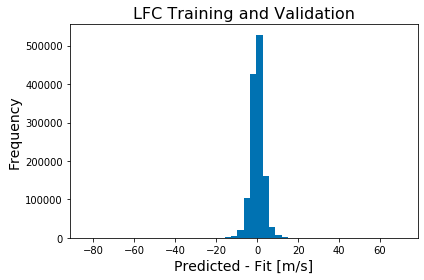

In [162]:
resids, rv_shifts_lfcTnV = [], []
for i in range(len(lfc_fits)):
    good_mask = np.isfinite(lfc_fits[i])
    resid = lfc_fits[i][good_mask]-lfc_info[i][2][good_mask]
    rv_shift = resid/lfc_info[i][2][good_mask] * c.value
    
    resids.append(resid)
    rv_shifts_lfcTnV.append(rv_shift)

cont_shifts = np.concatenate(rv_shifts_lfcTnV)

plt.figure()
plt.title('LFC Training and Validation',fontsize=title_font)
plt.xlabel('Predicted - Fit [m/s]',fontsize=label_font)
plt.ylabel('Frequency',fontsize=label_font)
plt.hist(cont_shifts,50);
plt.tight_layout()
plt.savefig('./Figures/Paper/lfcTnV.png')
plt.savefig('./Figures/Paper/lfcTnV.pdf')
print(np.std(cont_shifts))

#### ThAr Validation Test

## Comprison of All Methods

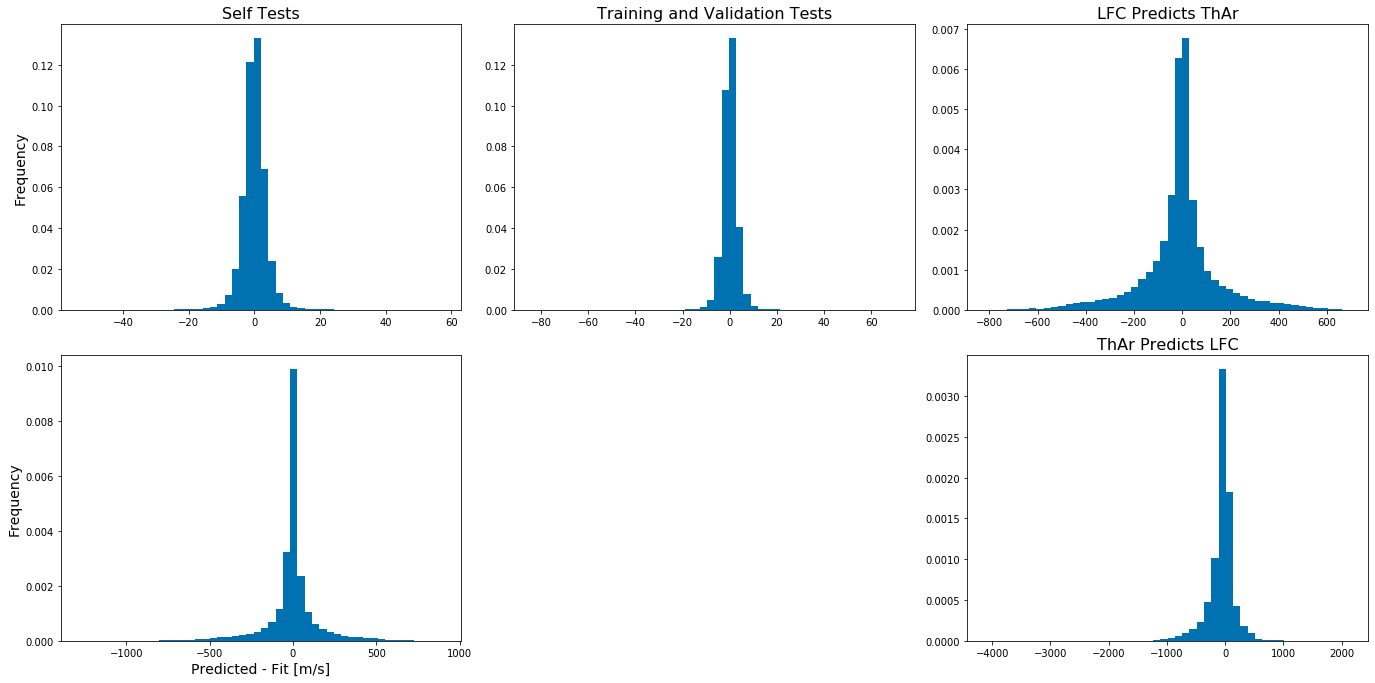

In [163]:
plt.figure(figsize=(6.4*3,4.8*2))
plt.subplot(2,3,1)
plt.title('Self Tests',fontsize=title_font)
plt.ylabel('Frequency',fontsize=label_font)
plt.hist(np.sort(np.concatenate(rv_shifts_lfcSelf))[100:-100],50,density=True)

plt.subplot(2,3,4)
plt.xlabel('Predicted - Fit [m/s]',fontsize=label_font)
plt.ylabel('Frequency',fontsize=label_font)
plt.hist(np.sort(np.concatenate(rv_shifts_tharSelf))[100:-100],50,density=True)

plt.subplot(2,3,2)
plt.title('Training and Validation Tests',fontsize=title_font)
plt.hist(np.concatenate(rv_shifts_lfcTnV),50,density=True)

#plt.subplot(2,3,5)
#plt.hist(np.concatenate(rv_shifts_tharTnV),50,density=True)

plt.subplot(2,3,3)
plt.title('LFC Predicts ThAr',fontsize=title_font)
plt.hist(np.concatenate(rv_shifts_lfcThar),50,density=True)

plt.subplot(2,3,6)
plt.title('ThAr Predicts LFC',fontsize=title_font)
plt.hist(np.concatenate(rv_shifts_tharLfc),50,density=True)

plt.tight_layout()
plt.savefig('./Figures/Paper/allHist.png')
plt.savefig('./Figures/Paper/allHist.pdf')

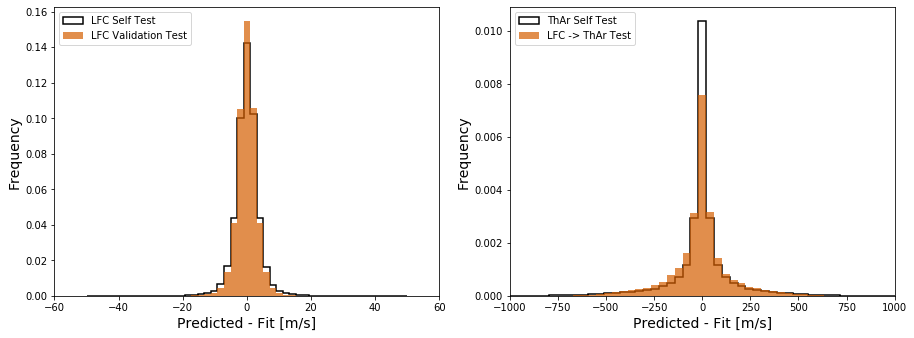

In [164]:
plt.figure(figsize=(6.4*2,4.8))
plt.subplot(1,2,1)
plt.xlabel('Predicted - Fit [m/s]',fontsize=label_font)
plt.ylabel('Frequency',fontsize=label_font)
b=np.linspace(-50,50,50)
plt.hist(np.sort(np.concatenate(rv_shifts_lfcSelf))[100:-100],bins=b,color='k',lw=1.5,
         histtype='step',density=True,label='LFC Self Test')
plt.hist(np.concatenate(rv_shifts_lfcTnV),bins=b, color=colors[2],
         alpha=0.7,density=True,label='LFC Validation Test')
plt.xlim(-60,60)
plt.legend(loc=2)

plt.subplot(1,2,2)
plt.xlabel('Predicted - Fit [m/s]',fontsize=label_font)
plt.ylabel('Frequency',fontsize=label_font)
b=np.linspace(-1000,1000,50)
plt.hist(np.sort(np.concatenate(rv_shifts_tharSelf))[100:-100],bins=b,color='k',lw=1.5,
         histtype='step',density=True,label='ThAr Self Test')
#plt.hist(np.concatenate(rv_shifts_tharTnV),bins=b,
#         alpha=0.5,density=True,label='ThAr Validation Test')
plt.hist(np.concatenate(rv_shifts_lfcThar),bins=b, color=colors[2],
         alpha=0.7,density=True,label='LFC -> ThAr Test')
#plt.hist(np.concatenate(rv_shifts_tharLfc),bins=b,
#         alpha=0.5,density=True,label='ThAr -> LFC Test')
plt.xlim(-1000,1000)
plt.legend(loc=2)

plt.tight_layout()
plt.savefig('./Figures/Paper/lfcGood.png')
plt.savefig('./Figures/Paper/lfcGood.pdf')

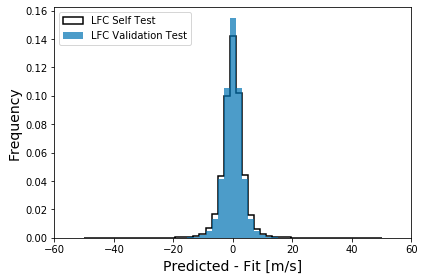

In [165]:
plt.figure()
plt.xlabel('Predicted - Fit [m/s]',fontsize=label_font)
plt.ylabel('Frequency',fontsize=label_font)
b=np.linspace(-50,50,50)
plt.hist(np.sort(np.concatenate(rv_shifts_lfcSelf))[100:-100],bins=b,color='k',lw=1.5,
         histtype='step',density=True,label='LFC Self Test')
plt.hist(np.concatenate(rv_shifts_lfcTnV),bins=b,
         alpha=0.7,density=True,label='LFC Validation Test')
plt.xlim(-60,60)
plt.legend(loc=2)

plt.tight_layout()
plt.savefig('./Figures/Paper/just_lfcGood.png')
plt.savefig('./Figures/Paper/just_lfcGood.pdf')

## Comparisons to Other Methods
Since neither of the methods we are comparing to are hierarchical, we only need one example ckpt/thid file.  However, it should be a file in the validation set to make it easier to draw comparisons with all the tests.

In [166]:
ckpt_test = lfc_valid[10]
thid_test = thar_valid[5]

### Parametric Model

In [167]:
# Original 2D Polynomial Fitting
def poly_fit_2d(x, y, data, deg=9, w=None):
    """
    Calculate the 2D polynomial fit coefficients assuming that the
    1D solution in x is approximately the correct answer.
    Parameters
    ----------
    x : ndarray
        The x positions
    y : ndarray
        The y postiions
    data : ndarray
        The data at each (x, y)
    deg : int or tuple
        The polynomial degree to fit. If a tuple: (deg_x, deg_y)
    w : ndarray
        A weight for each data point
    """
    if len(x) < 1:
        return None

    if w is None:
        w = np.ones_like(data)

    w = np.where(np.isnan(data) | np.isnan(w), 0, w)

    if isinstance(deg, int):
        deg = (deg, deg)

    deg_x, deg_y = deg

    def resid(coeffs):
        """The residual cost function for least_squares"""
        # Reshape the coefficient array into a matrix usable by polyval2d
        coeff_arr = coeffs.reshape(deg_x+1, -1)
        return (data - polyval2d(x, y, coeff_arr)) * w

    # Intialize the coefficients with the 1D polynomial fit
    coeffs = np.polyfit(x, data, deg=deg_x, w=w)[::-1, np.newaxis]

    # Gradually add higher order y parameters until the full 2D polynomial is fit
    for width in range(2, deg_y+2):
        guess = np.zeros((deg_x+1, width))
        guess[:, :-1] = coeffs
        result = least_squares(resid, guess.flatten(), method='lm')
        coeffs = result.x.reshape(deg_x+1, -1)

    return coeffs

In [168]:
# Original poly_val_2d eMethod
# Read in Data
x,m,w,e = readParams(ckpt_test)

# Fit
# Determine even lines from odd lines and vice versa
even = np.arange(len(x)) % 2
IA = even.astype(bool)
IB = (1 - even).astype(bool)

polyVal_w_fit = np.zeros_like(w)
polyVal_w_fit[IA] = polyval2d(x[IA],m[IA], poly_fit_2d(x[IB],m[IB],w[IB],deg=9,w=1/e[IB]**2))
polyVal_w_fit[IB] = polyval2d(x[IB],m[IB], poly_fit_2d(x[IA],m[IA],w[IA],deg=9,w=1/e[IA]**2))

#coeffs8 = poly_fit_2d(x,m,w,deg=8,w=1/e**2)
#polyVal_w_fit = polyval2d(x,m,coeffs8)

# Residuals
polyVal_resid_px = polyVal_w_fit-w
polyVal_resid_rv = polyVal_resid_px/w*c.value

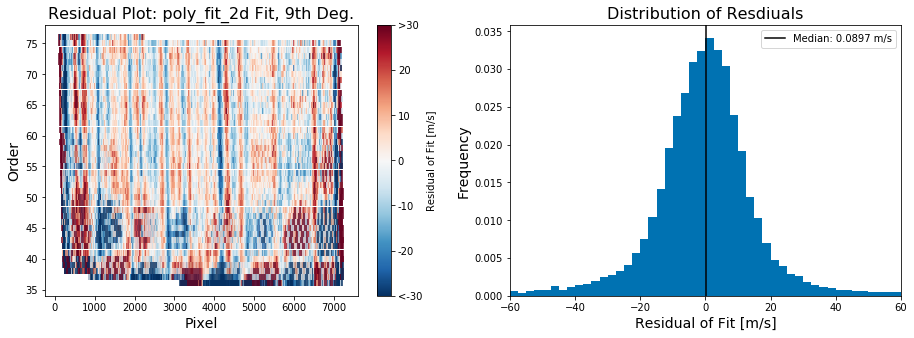

In [169]:
# Residual Plot and Histogram
plt.figure(figsize=(6.4*2,4.8))
plt.subplot(121)
plt.title('Residual Plot: poly_fit_2d Fit, 9th Deg.',fontsize=title_font)
plt.xlabel('Pixel',fontsize=label_font)
plt.ylabel('Order',fontsize=label_font)
plt.scatter(x,m,c=polyVal_resid_rv,vmin=-30,vmax=30,cmap='RdBu_r',marker='|')
cbar = plt.colorbar(label='Residual of Fit [m/s]')
cbar_labels = np.arange(-30,31,10).astype(str)
cbar_labels[0] = '<-30'
cbar_labels[-1] = '>30'
cbar.ax.set_yticklabels(cbar_labels)
plt.subplot(122)
plt.title('Distribution of Resdiuals',fontsize=title_font)
plt.xlabel('Residual of Fit [m/s]',fontsize=label_font)
plt.ylabel('Frequency',fontsize=label_font)
plt.hist(polyVal_resid_rv,np.arange(-100,100,2.5),density=True)
resid_med = np.median(polyVal_resid_rv)
plt.axvline(resid_med,color='k',
           label='Median: {:.3} m/s'.format(resid_med))
plt.legend()
plt.xlim(-60,60)
plt.tight_layout()
plt.savefig('./Figures/Paper/polyval2d.png')
plt.savefig('./Figures/Paper/polyval2d.pdf')

In [170]:
# Polynomial Fitting with Design Matrix
# Read in Data
x,m,w,e = readParams(ckpt_test)

# Fit
# Determine even lines from odd lines and vice versa
even = np.arange(len(x)) % 2
IA = even.astype(bool)
IB = (1 - even).astype(bool)

dsnM_w_fit = np.zeros_like(w)
dsnM_w_fit[IA] = poly_train_and_predict(x[IA], m[IA], x[IB], m[IB], w[IB], 1/e[IB]**2, 9)
dsnM_w_fit[IB] = poly_train_and_predict(x[IB], m[IB], x[IA], m[IA], w[IA], 1/e[IA]**2, 9)

#dsnM_w_fit = poly_train_and_predict(x, m, x, m, w, 1/e**2, 8)

# Residuals
dsnM_resid_px = dsnM_w_fit-w
dsnM_resid_rv = dsnM_resid_px/w*c.value

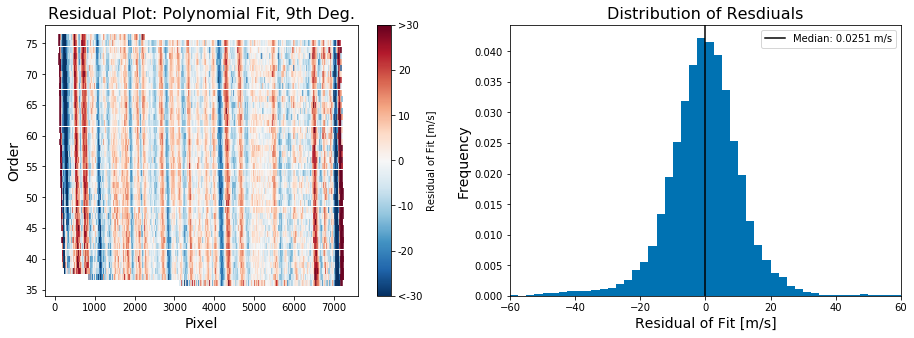

In [171]:
# Residual Plot and Histogram
plt.figure(figsize=(6.4*2,4.8))
plt.subplot(121)
plt.title('Residual Plot: Polynomial Fit, 9th Deg.',fontsize=title_font)
plt.xlabel('Pixel',fontsize=label_font)
plt.ylabel('Order',fontsize=label_font)
plt.scatter(x,m,c=dsnM_resid_rv,vmin=-30,vmax=30,cmap='RdBu_r',marker='|')
cbar = plt.colorbar(label='Residual of Fit [m/s]')
cbar_labels = np.arange(-30,31,10).astype(str)
cbar_labels[0] = '<-30'
cbar_labels[-1] = '>30'
cbar.ax.set_yticklabels(cbar_labels)
plt.subplot(122)
plt.title('Distribution of Resdiuals',fontsize=title_font)
plt.xlabel('Residual of Fit [m/s]',fontsize=label_font)
plt.ylabel('Frequency',fontsize=label_font)
plt.hist(dsnM_resid_rv,np.arange(-100,100,2.5),density=True)
resid_med = np.median(dsnM_resid_rv)
plt.axvline(resid_med,color='k',
           label='Median: {:.3} m/s'.format(resid_med))
plt.legend()
plt.xlim(-60,60)
plt.tight_layout()
plt.savefig('./Figures/Paper/designMatrix.png')
plt.savefig('./Figures/Paper/designMatrix.pdf')

### Non-Hierarchical Model

In [172]:
# Polynomial Fitting with Design Matrix
# Read in Data
x,m,w,e = readParams(ckpt_test)

# Fit
# Interp even lines from odd lines and vice versa
even = np.arange(len(x)) % 2
IA = even.astype(bool)
IB = (1 - even).astype(bool)

intp_w_fit = np.zeros_like(w)
intp_w_fit[IA] = interp_train_and_predict(x[IA], m[IA], x[IB], m[IB], w[IB], e[IB])
intp_w_fit[IB] = interp_train_and_predict(x[IB], m[IB], x[IA], m[IA], w[IA], e[IA])

# Residuals
intp_resid_px = intp_w_fit-w
intp_resid_rv = intp_resid_px/w*c.value

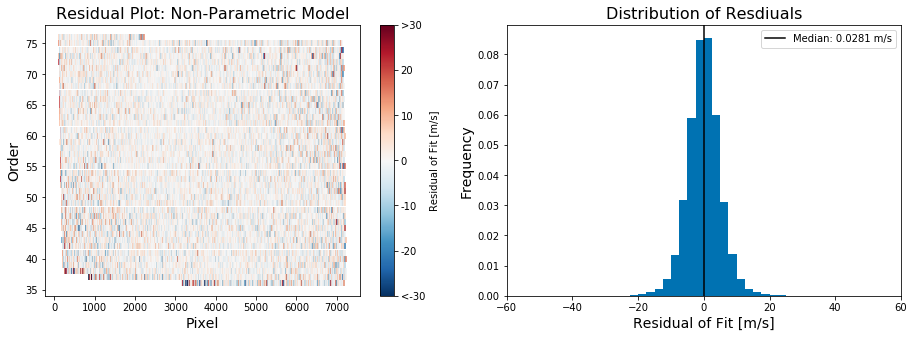

In [173]:
# Residual Plot and Histogram
plt.figure(figsize=(6.4*2,4.8))
plt.subplot(121)
plt.title('Residual Plot: Non-Parametric Model',fontsize=title_font)
plt.xlabel('Pixel',fontsize=label_font)
plt.ylabel('Order',fontsize=label_font)
plt.scatter(x,m,c=intp_resid_rv,vmin=-30,vmax=30,cmap='RdBu_r',marker='|')
cbar = plt.colorbar(label='Residual of Fit [m/s]')
cbar_labels = np.arange(-30,31,10).astype(str)
cbar_labels[0] = '<-30'
cbar_labels[-1] = '>30'
cbar.ax.set_yticklabels(cbar_labels)
plt.subplot(122)
plt.title('Distribution of Resdiuals',fontsize=title_font)
plt.xlabel('Residual of Fit [m/s]',fontsize=label_font)
plt.ylabel('Frequency',fontsize=label_font)
plt.hist(intp_resid_rv[np.isfinite(intp_resid_rv)],np.arange(-100,100,2.5),density=True)
resid_med = np.nanmedian(intp_resid_rv)
plt.axvline(resid_med,color='k',
           label='Median: {:.3} m/s'.format(resid_med))
plt.legend()
plt.xlim(-60,60)
plt.tight_layout()
plt.savefig('./Figures/Paper/noHierc.png')
plt.savefig('./Figures/Paper/noHierc.pdf')

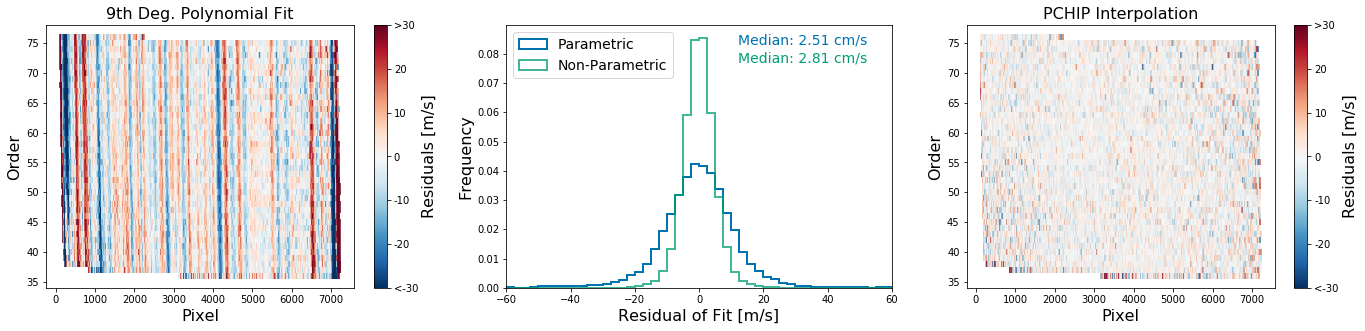

In [174]:
plt.style.use('seaborn-colorblind')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
label_font=16
# Residual Plot and Histogram
plt.figure(figsize=(6.4*3,4.7))
plt.subplot(131)
plt.title('9th Deg. Polynomial Fit',fontsize=title_font)
plt.xlabel('Pixel',fontsize=label_font)
plt.ylabel('Order',fontsize=label_font)
plt.scatter(x,m,c=dsnM_resid_rv,vmin=-30,vmax=30,cmap='RdBu_r',marker='|')
cbar = plt.colorbar(label='Residuals [m/s]')
cbar.set_label(label='Residuals [m/s]',size=label_font)
cbar_labels = np.arange(-30,31,10).astype(str)
cbar_labels[0] = '<-30'
cbar_labels[-1] = '>30'
cbar.ax.set_yticklabels(cbar_labels)
plt.subplot(132)
plt.xlabel('Residual of Fit [m/s]',fontsize=label_font)
plt.ylabel('Frequency',fontsize=label_font)
plt.hist(dsnM_resid_rv,np.arange(-100,100,2.5),histtype='step',lw=2,
         color=colors[0],density=True,label='Parametric')
plt.hist(intp_resid_rv[np.isfinite(intp_resid_rv)],np.arange(-100,100,2.5),
         color=colors[1],histtype='step',lw=2,
         density=True,alpha=0.75,label='Non-Parametric')
ax = plt.gca()
spacing=.07
resid_med = np.nanmedian(dsnM_resid_rv)
ax.text(.6,0.97,'Median: {:.3} cm/s'.format(resid_med*100),color=colors[0],
        verticalalignment='top',horizontalalignment='left',fontsize=14,transform=ax.transAxes)
resid_med = np.nanmedian(intp_resid_rv)
ax.text(.6,0.97-spacing,'Median: {:.3} cm/s'.format(resid_med*100),color=colors[1],
        verticalalignment='top',horizontalalignment='left',fontsize=14,transform=ax.transAxes)
plt.legend(loc=2,fontsize=14)
plt.xlim(-60,60)
plt.subplot(133)
plt.title('PCHIP Interpolation',fontsize=title_font)
plt.xlabel('Pixel',fontsize=label_font)
plt.ylabel('Order',fontsize=label_font)
plt.scatter(x,m,c=intp_resid_rv,vmin=-30,vmax=30,cmap='RdBu_r',marker='|')
cbar = plt.colorbar(label='Residuals [m/s]')
cbar.set_label(label='Residuals [m/s]',size=label_font)
cbar_labels = np.arange(-30,31,10).astype(str)
cbar_labels[0] = '<-30'
cbar_labels[-1] = '>30'
cbar.ax.set_yticklabels(cbar_labels)
plt.tight_layout()
plt.savefig('./Figures/Paper/parametricTest.png')
plt.savefig('./Figures/Paper/parametricTest.pdf')

In [52]:
errs = []
for file_name in ckpt_patch['files']:
    x,m,w,e = readParams(file_name)
    errs.append(e/w*c.value)
np.mean(np.concatenate(errs))

226.28325161738422

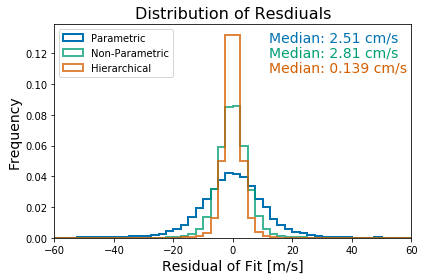

In [65]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.title('Distribution of Resdiuals',fontsize=title_font)
plt.xlabel('Residual of Fit [m/s]',fontsize=label_font)
plt.ylabel('Frequency',fontsize=label_font)
plt.hist(dsnM_resid_rv,np.arange(-100,100,2.5),histtype='step',lw=2,
         color=colors[0],density=True,label='Parametric')
plt.hist(intp_resid_rv[np.isfinite(intp_resid_rv)],np.arange(-100,100,2.5),
         color=colors[1],histtype='step',lw=2,
         density=True,alpha=0.75,label='Non-Parametric')
plt.hist(np.concatenate(rv_shifts_lfcTnV),np.arange(-100,100,2.5),
         color=colors[2],histtype='step',lw=2,
         density=True,alpha=0.75,label='Hierarchical')
ax = plt.gca()
spacing=.07
resid_med = np.nanmedian(dsnM_resid_rv)
ax.text(.6,0.97,'Median: {:.3} cm/s'.format(resid_med*100),color=colors[0],
        verticalalignment='top',horizontalalignment='left',fontsize=14,
        transform=ax.transAxes)
resid_med = np.nanmedian(intp_resid_rv)
ax.text(.6,0.97-spacing,'Median: {:.3} cm/s'.format(resid_med*100),color=colors[1],
        verticalalignment='top',horizontalalignment='left',fontsize=14,
        transform=ax.transAxes)
resid_med = np.nanmedian(np.concatenate(rv_shifts_lfcTnV))
ax.text(.6,0.97-spacing*2,'Median: {:.3} cm/s'.format(resid_med*100),color=colors[2],
        verticalalignment='top',horizontalalignment='left',fontsize=14,
        transform=ax.transAxes)
plt.legend(loc=2)
plt.xlim(-60,60)

plt.tight_layout()
plt.savefig('./Figures/Paper/weWin.png')
plt.savefig('./Figures/Paper/weWin.pdf')

In [54]:
nepc=100
newx,newm,neww,newe = readFile(ckpt_patch['files'][nepc])
file_time = ckpt_patch['times'][nepc]

denoised_xs = evalWaveSol(file_time, thid_patch, intp_deg=1)[0]
m = thid_patch['orders'].copy()
w = thid_patch['waves'].copy()

w_fit = interp_train_and_predict(newx, newm,
                                 denoised_xs, m, w,
                                 orders=range(46,68),
                                 e=None, interp_deg='pchip')
resid_lfc = (w_fit-neww)/neww*c.value
xl = newx.copy()
ml = newm.copy()

In [55]:
file_num  = 0
file_name = thar_valid[file_num]
file_time = thar_times_valid[file_num]

newx,newm,neww,newe = readFile(file_name)

denoised_xs = evalWaveSol(file_time, thid_patch, intp_deg=1)[0]
m = thid_patch['orders'].copy()
w = thid_patch['waves'].copy()

w_fit = interp_train_and_predict(newx, newm,
                                 denoised_xs, m, w,
                                 orders=range(46,68),
                                 e=None, interp_deg='pchip')
resid_thar = (w_fit-neww)/neww*c.value
xt = newx.copy()
mt = newm.copy()

In [56]:
# Polynomial Fitting with Design Matrix
# Read in Data
dsnM_xt,dsnM_mt,dsnM_w,e = readFile(thid_patch['files'][10])

# Fit
# Determine even lines from odd lines and vice versa
even = np.arange(len(dsnM_xt)) % 2
IA = even.astype(bool)
IB = (1 - even).astype(bool)

dsnM_w_fit_thar = np.zeros_like(dsnM_w)
dsnM_w_fit_thar[IA] = poly_train_and_predict(dsnM_xt[IA], dsnM_mt[IA],
                                             dsnM_xt[IB], dsnM_mt[IB], dsnM_w[IB],
                                             np.ones_like(dsnM_xt[IB],dtype=float), 9)
dsnM_w_fit_thar[IB] = poly_train_and_predict(dsnM_xt[IB], dsnM_mt[IB],
                                             dsnM_xt[IA], dsnM_mt[IA], dsnM_w[IA],
                                             np.ones_like(dsnM_xt[IA],dtype=float), 9)

#dsnM_w_fit = poly_train_and_predict(x, m, x, m, w, 1/e**2, 8)

# Residuals
dsnM_resid_px_thar = dsnM_w_fit_thar-dsnM_w
dsnM_resid_rv_thar = dsnM_resid_px_thar/dsnM_w*c.value

In [57]:
# Original poly_val_2d eMethod
# Read in Data
poly_xt,poly_mt,poly_wt,e = readFile(thid_patch['files'][10])

# Fit
# Determine even lines from odd lines and vice versa
even = np.arange(len(poly_xt)) % 2
IA = even.astype(bool)
IB = (1 - even).astype(bool)

polyVal_w_fit = np.zeros_like(poly_wt)
polyVal_w_fit[IA] = polyval2d(poly_xt[IA],poly_mt[IA],
                              poly_fit_2d(poly_xt[IB],poly_mt[IB],poly_wt[IB],
                              deg=9,w=np.ones_like(e[IB])))
polyVal_w_fit[IB] = polyval2d(poly_xt[IB],poly_mt[IB],
                              poly_fit_2d(poly_xt[IA],poly_mt[IA],poly_wt[IA],
                              deg=9,w=np.ones_like(e[IA])))

#coeffs8 = poly_fit_2d(x,m,w,deg=8,w=1/e**2)
#polyVal_w_fit = polyval2d(x,m,coeffs8)

# Residuals
polyVal_resid_px_thar = polyVal_w_fit-poly_wt
polyVal_resid_rv_thar = polyVal_resid_px_thar/poly_wt*c.value

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RankWarning: Polyfit may be poorly conditioned
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned


In [58]:
# Polynomial Fitting with Design Matrix
# Read in Data
intp_x,intp_m,intp_w,intp_e = readFile(thid_patch['files'][10])

# Fit
# Interp even lines from odd lines and vice versa
even = np.arange(len(intp_x)) % 2
IA = even.astype(bool)
IB = (1 - even).astype(bool)

intp_w_fit = np.zeros_like(intp_w)
intp_w_fit[IA] = interp_train_and_predict(intp_x[IA], intp_m[IA],
                                          intp_x[IB], intp_m[IB], intp_w[IB],
                                          np.ones_like(e[IB]))
intp_w_fit[IB] = interp_train_and_predict(intp_x[IB], intp_m[IB],
                                          intp_x[IA], intp_m[IA], intp_w[IA],
                                          np.ones_like(e[IA]))

# Residuals
intp_resid_px_thar = intp_w_fit-intp_w
intp_resid_rv_thar = intp_resid_px_thar/intp_w*c.value

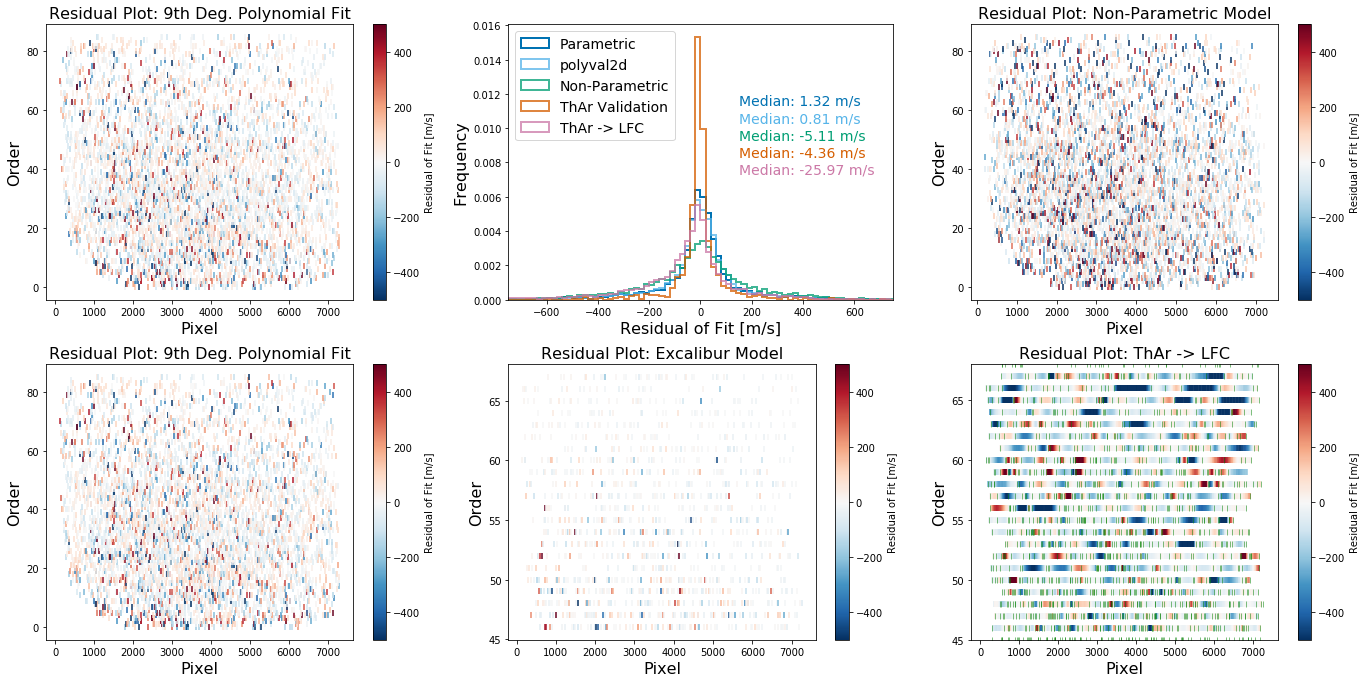

In [59]:
plt.style.use('seaborn-colorblind')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
label_font=16
# Residual Plot and Histogram
plt.figure(figsize=(6.4*3,4.8*2))
plt.subplot(231)
plt.title('Residual Plot: 9th Deg. Polynomial Fit',fontsize=title_font)
plt.xlabel('Pixel',fontsize=label_font)
plt.ylabel('Order',fontsize=label_font)
plt.scatter(dsnM_xt,dsnM_mt,c=dsnM_resid_rv_thar,vmin=-500,vmax=500,cmap='RdBu_r',marker='|')
cbar = plt.colorbar(label='Residual of Fit [m/s]')

plt.subplot(234)
plt.title('Residual Plot: 9th Deg. Polynomial Fit',fontsize=title_font)
plt.xlabel('Pixel',fontsize=label_font)
plt.ylabel('Order',fontsize=label_font)
plt.scatter(poly_xt,poly_mt,c=polyVal_resid_rv_thar,vmin=-500,vmax=500,cmap='RdBu_r',marker='|')
cbar = plt.colorbar(label='Residual of Fit [m/s]')

plt.subplot(232)
plt.xlabel('Residual of Fit [m/s]',fontsize=label_font)
plt.ylabel('Frequency',fontsize=label_font)
plt.hist(dsnM_resid_rv_thar,np.arange(-1000,1000,20),histtype='step',lw=2,
         color=colors[0],density=True,label='Parametric')
plt.hist(polyVal_resid_rv_thar,np.arange(-1000,1000,20),
         color=colors[5],histtype='step',lw=2,
         density=True,alpha=0.75,label='polyval2d')
plt.hist(intp_resid_rv_thar,np.arange(-1000,1000,20),
         color=colors[1],histtype='step',lw=2,
         density=True,alpha=0.75,label='Non-Parametric')
plt.hist(resid_thar,np.arange(-1000,1000,20),
         color=colors[2],histtype='step',lw=2,
         density=True,alpha=0.75,label='ThAr Validation')
plt.hist(resid_lfc,np.arange(-1000,1000,20),
         color=colors[3],histtype='step',lw=2,
         density=True,alpha=0.75,label='ThAr -> LFC')
ax = plt.gca()
spacing=.001
resid_med = round(np.nanmedian(dsnM_resid_rv_thar),2)
xtxt=150
ax.text(xtxt,0.012,'Median: {} m/s'.format(resid_med),color=colors[0],
        verticalalignment='top',horizontalalignment='left',fontsize=14)
resid_med = round(np.nanmedian(polyVal_resid_rv_thar),2)
ax.text(xtxt,0.012-spacing,'Median: {} m/s'.format(resid_med),color=colors[5],
        verticalalignment='top',horizontalalignment='left',fontsize=14)
resid_med = round(np.nanmedian(intp_resid_rv_thar),2)
ax.text(xtxt,0.012-spacing*2,'Median: {} m/s'.format(resid_med),color=colors[1],
        verticalalignment='top',horizontalalignment='left',fontsize=14)
resid_med = round(np.nanmedian(resid_thar),2)
ax.text(xtxt,0.012-spacing*3,'Median: {} m/s'.format(resid_med),color=colors[2],
        verticalalignment='top',horizontalalignment='left',fontsize=14)
resid_med = round(np.nanmedian(resid_lfc),2)
ax.text(xtxt,0.012-spacing*4,'Median: {} m/s'.format(resid_med),color=colors[3],
        verticalalignment='top',horizontalalignment='left',fontsize=14)
plt.legend(loc=2,fontsize=14)
plt.xlim(-750,750)

plt.subplot(233)
plt.title('Residual Plot: Non-Parametric Model',fontsize=title_font)
plt.xlabel('Pixel',fontsize=label_font)
plt.ylabel('Order',fontsize=label_font)
plt.scatter(intp_x,intp_m,c=intp_resid_rv_thar,vmin=-500,vmax=500,cmap='RdBu_r',marker='|')
cbar = plt.colorbar(label='Residual of Fit [m/s]')

plt.subplot(235)
plt.title('Residual Plot: Excalibur Model',fontsize=title_font)
plt.xlabel('Pixel',fontsize=label_font)
plt.ylabel('Order',fontsize=label_font)
plt.scatter(xt,mt,c=resid_thar,vmin=-500,vmax=500,cmap='RdBu_r',marker='|')
cbar = plt.colorbar(label='Residual of Fit [m/s]')

plt.subplot(236)
plt.title('Residual Plot: ThAr -> LFC',fontsize=title_font)
plt.xlabel('Pixel',fontsize=label_font)
plt.ylabel('Order',fontsize=label_font)
plt.scatter(xl,ml,c=resid_lfc,vmin=-500,vmax=500,cmap='RdBu_r',marker='|')
cbar = plt.colorbar(label='Residual of Fit [m/s]')
plt.plot(xt,mt,'g|',alpha=0.5)
plt.ylim(45,68)

plt.tight_layout()
plt.savefig('./Figures/Paper/parametricTest_thar.png')
plt.savefig('./Figures/Paper/parametricTest_thar.pdf')

In [60]:
np.argmin(abs(thid_patch['times'][10]-ckpt_patch['times']))

116

In [61]:
# Polynomial Fitting with Design Matrix
# Read in Data
dsnM_xl,dsnM_ml,dsnM_wl,e = readFile(ckpt_patch['files'][116])
dsnM_xt,dsnM_mt,dsnM_wt,e = readFile(thid_patch['files'][10])

# Fit
# Determine even lines from odd lines and vice versa
dsnM_w_fit_thar = poly_train_and_predict(dsnM_xl, dsnM_ml,
                                         dsnM_xt, dsnM_mt, dsnM_wt,
                                         np.ones_like(dsnM_xt,dtype=float), 9)

# Residuals
dsnM_resid_px_thar = dsnM_w_fit_thar-dsnM_wl
dsnM_resid_rv_thar = dsnM_resid_px_thar/dsnM_wl*c.value

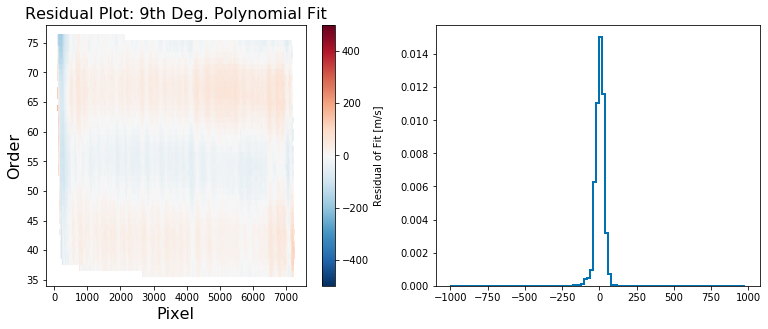

In [62]:
plt.figure(figsize=(6.4*2,4.8))
plt.subplot(121)
plt.title('Residual Plot: 9th Deg. Polynomial Fit',fontsize=title_font)
plt.xlabel('Pixel',fontsize=label_font)
plt.ylabel('Order',fontsize=label_font)
plt.scatter(dsnM_xl,dsnM_ml,c=dsnM_resid_rv_thar,vmin=-500,vmax=500,cmap='RdBu_r',marker='|')
cbar = plt.colorbar(label='Residual of Fit [m/s]')

plt.subplot(122)
plt.hist(dsnM_resid_rv_thar,np.arange(-1000,1000,20),histtype='step',lw=2,
         color=colors[0],density=True,label='Parametric');

In [63]:
np.argmin(abs(ckpt_patch['times'][56]-thid_patch['times']))

4

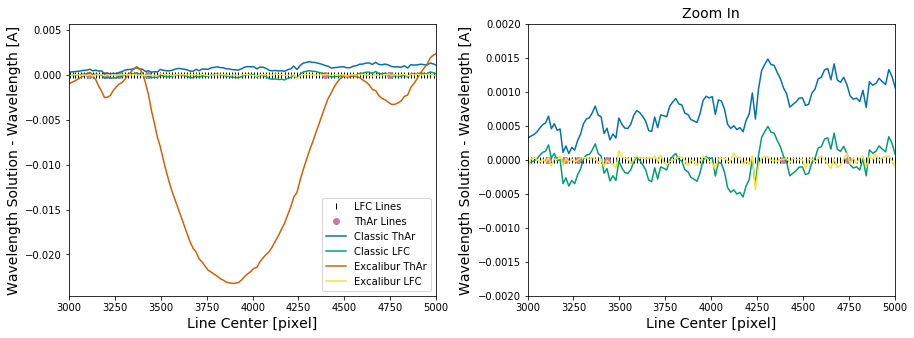

In [122]:
nord=66

# Read in Data
xl,ml,wl,el = readFile(ckpt_patch['files'][56])
xt,mt,wt,et = readFile(thid_patch['files'][4])

IL = ml==nord
IT = mt==nord

x_arr = np.linspace(0,7920,10000)
y_arr = np.zeros_like(x_arr)+nord

x_arr = xl[IL]
y_arr = ml[IL]

# Polynomial Fitting with Design Matrix
poly_fit_thar = poly_train_and_predict(x_arr, y_arr, xt, mt, wt,
                                       np.ones_like(xt,dtype=float), 9)
poly_fit_lfc  = poly_train_and_predict(x_arr, y_arr, xl, ml, wl, el, 9)

# Interpolated Fits
dnxs = evalWaveSol(ckpt_patch['times'][56], thid_patch, intp_deg=1)[0]
m = thid_patch['orders']
w = thid_patch['waves']
intp_fit_thar = interp_train_and_predict(x_arr, y_arr, dnxs, m, w)
dnxs = evalWaveSol(ckpt_patch['times'][56], ckpt_patch_train, intp_deg=1)[0]
m = ckpt_patch_train['orders']
w = ckpt_patch_train['waves']
intp_fit_lfc  = interp_train_and_predict(x_arr, y_arr, dnxs, m, w)

label_font = 14
plt.figure(figsize=(6.4*2,4.8))
plt.subplot(121)
#plt.title('Residuals of Wavelength Solution',fontsize=label_font)
plt.xlabel('Line Center [pixel]',fontsize=label_font)
plt.ylabel('Wavelength Solution - Wavelength [A]',fontsize=label_font)
plt.plot(xl[IL],wl[IL]-wl[IL],'k|',label='LFC Lines')
plt.plot(xt[IT],wt[IT]-wt[IT],'o',color=colors[3],label='ThAr Lines')

plt.plot(x_arr,poly_fit_thar-wl[IL],label='Classic ThAr')
plt.plot(x_arr,poly_fit_lfc -wl[IL],label='Classic LFC')

plt.plot(x_arr,intp_fit_thar-wl[IL],label='Excalibur ThAr')
plt.plot(np.nan,np.nan)
plt.plot(x_arr,intp_fit_lfc -wl[IL],label='Excalibur LFC')

plt.xlim(3000,5000)
plt.legend()


plt.subplot(122)
plt.title('Zoom In',fontsize=label_font)
plt.xlabel('Line Center [pixel]',fontsize=label_font)
plt.ylabel('Wavelength Solution - Wavelength [A]',fontsize=label_font)
plt.plot(xl[IL],wl[IL]-wl[IL],'k|')
plt.plot(xt[IT],wt[IT]-wt[IT],'o',color=colors[3])

plt.plot(x_arr,poly_fit_thar-wl[IL],label='Poly ThAr')
plt.plot(x_arr,poly_fit_lfc -wl[IL],label='Poly LFC')

#plt.plot(x_arr,intp_fit_thar-wl[IL],label='Excalibur ThAr')
plt.plot(np.nan,np.nan)
plt.plot(np.nan,np.nan)
plt.plot(x_arr,intp_fit_lfc -wl[IL],label='Excalibur LFC')

plt.xlim(3000,5000)
plt.ylim(-0.002,0.002)

plt.tight_layout()
plt.savefig('./Figures/Paper/waveResids.png')
plt.savefig('./Figures/Paper/waveResids.pdf')